# Sentiment analysis - Women's ecommerce clothing reviews 
-------------------------------

## Context:

Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. 

This [Women’s Clothing E-Commerce](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews)  dataset revolves around the reviews written by customers on a variety of clothing products offered by an anonymous e-commerce. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with “retailer”. In this kernel, we will use the data to build a machine learning model that can predict whether or not a customer would recommend a purchased item of clothing based on solely their written review.

## About the dataset:
This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

* **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
* **Age**: Positive Integer variable of the reviewers age.
* **Title**: String variable for the title of the review.
* **Review Text**: String variable for the review body.
* **Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
* **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
* **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
* **Division Name**: Categorical name of the product high level division.
* **Department Name**: Categorical name of the product department name.
* **Class Name**: Categorical name of the product class name.

## Kernel content

I. Import libraries and load the dataset

II. Exploratory Data Analysis (EDA)
    * 1. Data imputation
    * 2. Numerical variable analysis
    * 3. Categorical variable analysis
    * 4. Feature transformation
III. Text preprocessing

IV. Building sentiment classifier
    
### I. Import libraries and load the dataset

In [1]:
# Import libraries:
# Data handling and processing
import pandas as pd
import numpy as np
import warnings

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Statistics
from scipy import stats
import statsmodels.api as sm
from scipy.stats import randint as sp_randint
from time import time
import pandas_profiling
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn import metrics

# NLP
import nltk
nltk.download('wordnet')
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

# Edit pandas display option to show more rows and columns:
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vilandao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)
df.columns = ['ID', 'Age', 'Title', 'Review', 'Rating', 'Recommended', 
              'Pos_feedback', 'Division', 'Department', 'Class']

In [3]:
# Print out the first 5 rows of dataset:
df.head()

,ID,Age,Title,Review,Rating,Recommended,Pos_feedback,Division,Department,Class
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
# Print out the shape of the dataset:
print('The shape of the dataset is', df.shape)

The shape of the dataset is (23486, 10)


### II. Exploratory Data Analysis:
### 1. Data impuation:
Let's first explore our data and deal with missing values

In [5]:
# Inspect column datatype and missing value:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
ID              23486 non-null int64
Age             23486 non-null int64
Title           19676 non-null object
Review          22641 non-null object
Rating          23486 non-null int64
Recommended     23486 non-null int64
Pos_feedback    23486 non-null int64
Division        23472 non-null object
Department      23472 non-null object
Class           23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [6]:
# Inspect columns with missing value:
null = df.isnull().sum()/len(df)
null[null>0]

Title        0.162
Review       0.036
Division     0.001
Department   0.001
Class        0.001
dtype: float64

There are 5 columns with missing values in the dataset. 'Title' is the column with the most missing values of 16%. Let's fill in missing values and take a look at the dataset.

In [7]:
# Merging text features and drop 'Title' column:
df['Review'] = df['Title'] + ' ' + df['Review']
df['Review'].astype(str)
df.drop('Title', axis=1, inplace=True)

# Fill missing reviews with 'None':
df['Review'] =  df['Review'].fillna(value='None')

# Fill missing values for divison name, department name and class name 
# with the most common value for each column
df['Division'] = df['Division'].fillna(df['Division'].mode()[0])
df['Department'] = df['Department'].fillna(df['Department'].mode()[0])
df['Class'] = df['Class'].fillna(df['Class'].mode()[0])

# Add 'Review_length' variable that counts the length of each review:
df['Review_length'] = df['Review'].apply(len)

# Apply polarity and subjectivity of text:
df[['Polarity', 'Subjectivity']] = df['Review'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [8]:
df.head()

,ID,Age,Review,Rating,Recommended,Pos_feedback,Division,Department,Class,Review_length,Polarity,Subjectivity
0,767,33,None,4,1,0,Initmates,Intimate,Intimates,4,0.000,0.000
1,1080,34,None,5,1,4,General,Dresses,Dresses,4,0.000,0.000
2,1077,60,Some major design flaws I had such high hopes ...,3,0,0,General,Dresses,Dresses,524,0.073,0.362
3,1049,50,"My favorite buy! I love, love, love this jumps...",5,1,0,General Petite,Bottoms,Pants,141,0.561,0.679
4,847,47,Flattering shirt This shirt is very flattering...,5,1,6,General,Tops,Blouses,209,0.513,0.569


Notice that we used Textblob to create 2 new columns, namely 'Polarity' and 'Subjectivity' from our reviews. 

Polarity in sentiment analysis refers to identifying sentiment orientation, either a sentence is positive, neutral, or negative in written or spoken language. 
Language can contain expressions that are objective or subjective. Objective expressions are facts. Subjective expressions are opinions that describe people’s feelings towards a specific subject or topic. Take the following expressions:

* This apple is red.
* This apple tastes good.

While the first expression is objective, the second expression is subjective as it expresses an opinion towards the taste of the apple.

In [9]:
# Let's check if there's still any null value left in the dataset:
null = df.isnull().sum()/len(df)
null[null>0]

Series([], dtype: float64)

### 2. Numeric variable analysis

In [10]:
# Print out the statistics of numeric variables:
df.describe()

,ID,Age,Rating,Recommended,Pos_feedback,Review_length,Polarity,Subjectivity
count,23486.000,23486.000,23486.000,23486.000,23486.000,23486.000,23486.000,23486.000
mean,918.119,43.199,4.196,0.822,2.536,284.180,0.223,0.482
std,203.299,12.280,1.110,0.382,5.702,180.987,0.186,0.238
min,0.000,18.000,1.000,0.000,0.000,4.000,-0.988,0.000
25%,861.000,34.000,4.000,1.000,0.000,142.000,0.067,0.436
50%,936.000,41.000,5.000,1.000,1.000,287.000,0.223,0.545
75%,1078.000,52.000,5.000,1.000,3.000,457.000,0.344,0.631
max,1205.000,99.000,5.000,1.000,122.000,557.000,1.000,1.000


Just looking at the table above, we can gain some general overview of the dataset:
    * The youngest shoppers are 18 years old while the oldest ones are 99 years old
    * There are 5 values for ratings ranging from 1 to 5
    * The most popular review has 122 thumb up!
    * The longest review has over 550 words 

In [11]:
# Let's take a look at how many clothing item we have on the list:
print('There are a total of ' + str(df['ID'].nunique()) + ' unique items in this dataset')

There are a total of 1206 unique items in this dataset


Text(0.5, 1.0, 'Distribution of shopper age')

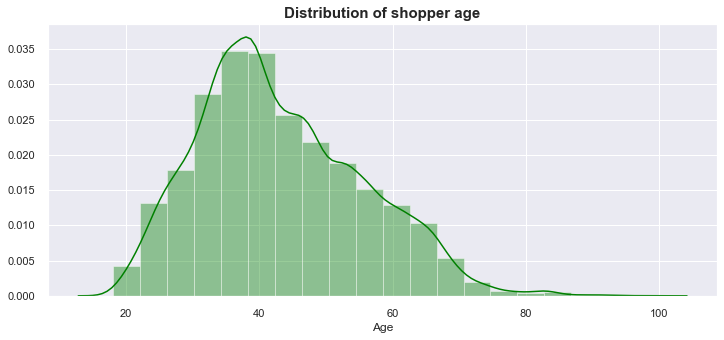

In [12]:
# What does the age of the shoppers?
sns.set(style='darkgrid')
plt.figure(figsize= (12,5))

sns.distplot(df['Age'], color='green', bins=20)
plt.title('Distribution of shopper age', fontsize=15, fontweight='bold' )

From the chart, we can see that the majority of shoppers falls between 25 to 55 years old. Around 40 years old is when the histogram peaks.

Different Age Group Count:
<=100      167
<=25      1223
<=75      2270
<=60      6682
<=45     13144
Name: Age, dtype: int64


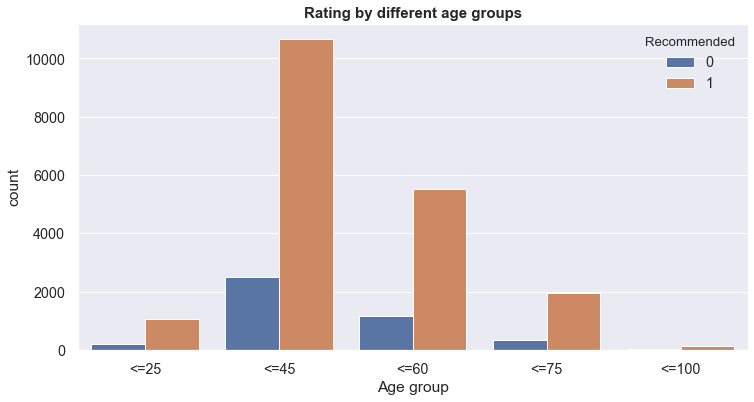

In [13]:
# Categorize age into age groups:
age = pd.cut(df['Age'],bins = [0, 25, 45, 60, 75, 100],labels = ['<=25', '<=45', '<=60', '<=75', '<=100',])
print('Different Age Group Count:')
print(age.value_counts().sort_values())

# Plot how likely different age group would recommend products:
plt.figure(figsize=(12,6))
sns.set(font_scale=1.3)

sns.countplot(x=age,hue=df['Recommended'])
plt.title('Rating by different age groups', fontsize=15, fontweight='bold')
plt.xlabel('Age group')
plt.show()

Interesting! It looks like the age group that is between 25 and 60 gives the most recommendation.

Text(0.5, 1.0, 'Recommendation by ratings')

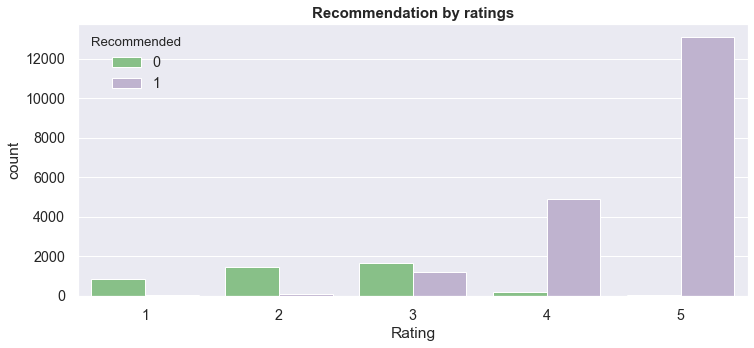

In [14]:
# Plot the frequency of ratings against recommendation:
plt.figure(figsize=(12,5))
sns.set(font_scale=1.3)
sns.countplot(x='Rating', hue='Recommended', data=df, palette='Accent')
plt.title('Recommendation by ratings', fontsize=15, fontweight='bold')

It looks like items with rating from 3 and above are those are recommended by shoppers.

Text(0.5, 1.0, 'Review length by rating')

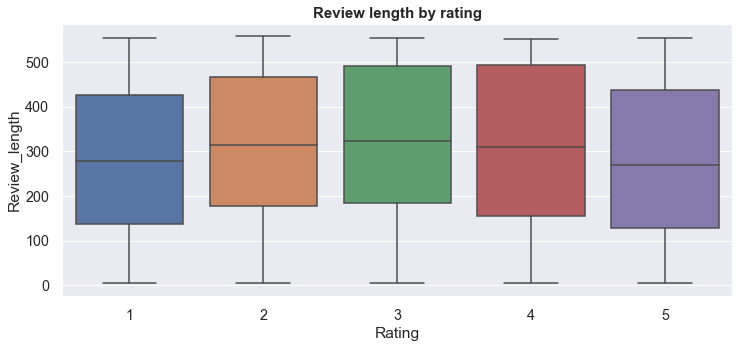

In [15]:
# Let's look at review length:
plt.figure(figsize=(12,5))
sns.set(font_scale=1.3)
sns.boxplot(x='Rating', y='Review_length', data=df)
plt.title('Review length by rating', fontsize=15, fontweight='bold')

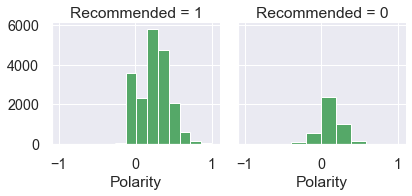

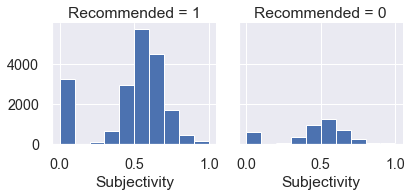

In [16]:
# Visualising polarity between recommending and non-recommending customers, then getting value counts
g = sns.FacetGrid(df, col='Recommended', col_order=[1, 0])
g = g.map(plt.hist, 'Polarity', bins=10, color='g')

g = sns.FacetGrid(df, col='Recommended', col_order=[1, 0])
g = g.map(plt.hist, 'Subjectivity', bins=10, color='b')

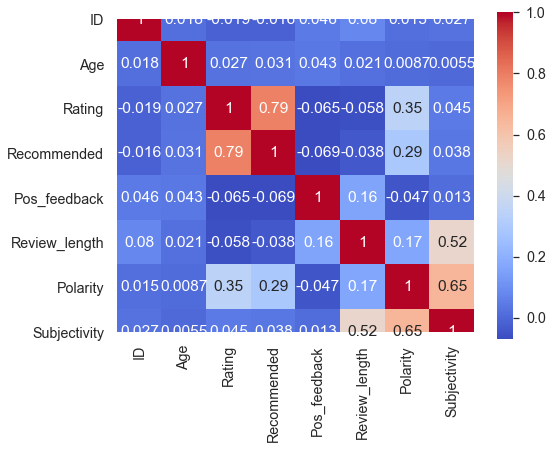

In [17]:
# Correlation matrix
corr = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', square = True)

This above correlation matrix shows the correlation coefficients between variables. As we can see, 'Rating' and 'Recommended' are highly positively correlated. This is intuitive since generally, the higher the rating, the more likely an item will be recommended and vice versa. 

Even though these 2 features are highly correlated, they are not perfectly correlated(the change in value of one variable is exactly proportional to the change in value of the other). This is because if we look at the above chart which shows recommendation by rating, there are items with 3 ratings that are recommended and not recommended at the same time.

Now let's explore our categorical and text variables

### 3. Categorical variable analysis

In [18]:
# Explore categorical variables:
df.describe(include=object)

,Review,Division,Department,Class
count,23486,23486,23486,23486
unique,19672,3,6,20
top,None,General,Tops,Dresses
freq,3811,13864,10482,6333


Text(0.5, 1.0, 'Recommendation by department')

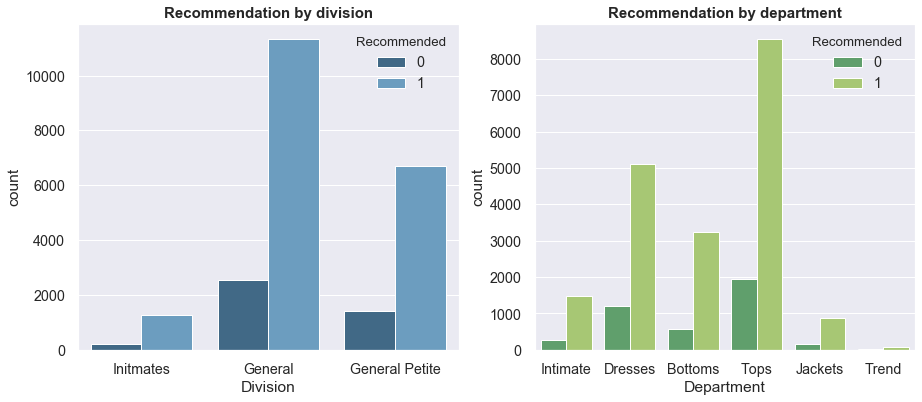

In [19]:
# Plot recommendation by Division and Department
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x='Division', hue='Recommended', data=df, palette='Blues_d')
plt.title('Recommendation by division', fontsize=15, fontweight='bold')

plt.subplot(1,2,2)
sns.countplot(x='Department', hue='Recommended', data=df, palette='summer')
plt.title('Recommendation by department', fontsize=15, fontweight='bold')

Text(0, 0.5, 'Average Rating')

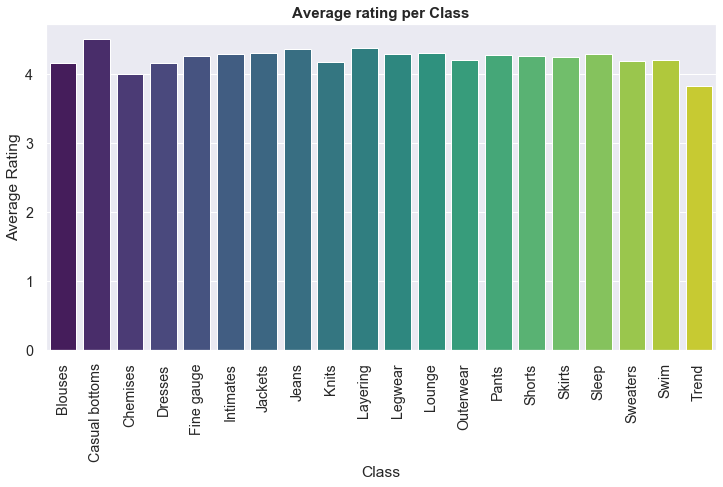

In [20]:
# Plot Average rating by different class of clothes:
avg = df.groupby('Class')['Rating'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.barplot(x='Class', y='Rating', data=avg, palette='viridis')
plt.title('Average rating per Class', fontsize=15, fontweight='bold')
plt.ylabel('Average Rating')

It looks like Casual bottom, Jeans and Layering have higher average rating than other clothing items. 

### 4. Feature transformation:

The next step we'll have to do is to encode our categorical variables.

In [21]:
# Encode class using LabelEncoder:
encoder1 = LabelEncoder()
df['Class'] = encoder1.fit_transform(df['Class'].values).tolist()

In [22]:
# Encode division and department using OneHotEncoder method:
df = pd.get_dummies(data=df, columns=['Division', 'Department'])
df.head()

,ID,Age,Review,Rating,Recommended,Pos_feedback,Class,Review_length,Polarity,Subjectivity,Division_General,Division_General Petite,Division_Initmates,Department_Bottoms,Department_Dresses,Department_Intimate,Department_Jackets,Department_Tops,Department_Trend
0,767,33,None,4,1,0,5,4,0.000,0.000,0,0,1,0,0,1,0,0,0
1,1080,34,None,5,1,4,3,4,0.000,0.000,1,0,0,0,1,0,0,0,0
2,1077,60,Some major design flaws I had such high hopes ...,3,0,0,3,524,0.073,0.362,1,0,0,0,1,0,0,0,0
3,1049,50,"My favorite buy! I love, love, love this jumps...",5,1,0,13,141,0.561,0.679,0,1,0,1,0,0,0,0,0
4,847,47,Flattering shirt This shirt is very flattering...,5,1,6,0,209,0.513,0.569,1,0,0,0,0,0,0,1,0


All of our categorical variables have now been encoded and transformed!

### III. Text data processing

In [23]:
# Create a dataframe that only contain text review and target variable:
text_df= df[['Review', 'Recommended']]

In [24]:
# Text processing:
stop_words = text.ENGLISH_STOP_WORDS

def process_text(text):
    text = text.str.lower() # transform all text to lowercase
    text = text.str.strip() # strip away all whitespaces
    text = text.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x])) # remove special characters
    text = text.str.replace('[^\w\s]', '') # remove punctuation
    text = text.str.replace('\d+', '') # remove numbers
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) # remove stopwords
    text = text.astype(str) # transform all text to string
    return text

In [25]:
# Applying process_text function to data
text_df['Filtered_review'] = process_text(text_df['Review'])

In [26]:
# Instantiate the Word tokenizer & Word lemmatizer:
tokenizer = nltk.tokenize.RegexpTokenizer('\s+', gaps = True)
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
    
# Apply the word lemmatizer function to data:
text_df['Filtered_review'] = text_df['Filtered_review'].apply(lemmatize_text)
text_df.head(10)

,Review,Recommended,Filtered_review
0,None,1,[]
1,None,1,[]
2,Some major design flaws I had such high hopes ...,0,"[major, design, flaw, high, hope, dress, reall..."
3,"My favorite buy! I love, love, love this jumps...",1,"[favorite, buy, love, love, love, jumpsuit, fu..."
4,Flattering shirt This shirt is very flattering...,1,"[flattering, shirt, shirt, flattering, adjusta..."
5,Not for the very petite I love tracy reese dre...,0,"[petite, love, tracy, reese, dress, petite, ju..."
6,Cagrcoal shimmer fun I aded this in my basket ...,1,"[cagrcoal, shimmer, fun, aded, basket, hte, mi..."
7,"Shimmer, surprisingly goes with lots I ordered...",1,"[shimmer, surprisingly, go, lot, ordered, carb..."
8,Flattering I love this dress. i usually get an...,1,"[flattering, love, dress, usually, x, run, lit..."
9,"Such a fun dress! I'm 5""5' and 125 lbs. i orde...",1,"[fun, dress, im, lb, ordered, s, petite, make,..."


In [27]:
# Create 2 different recommended and not_recommended dataframe:
recommended = text_df[text_df['Recommended']==1]
not_recommended = text_df[text_df['Recommended']==0]

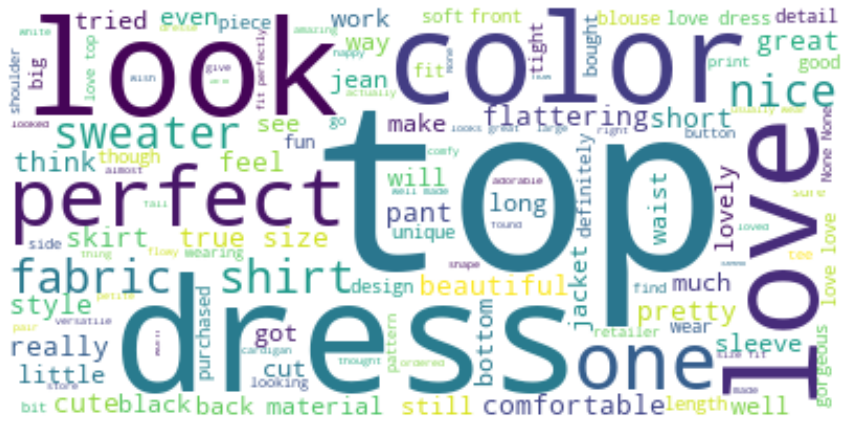

In [28]:
# Create wordcloud of recommended reviews:
wordcloud = WordCloud(background_color="white").generate(" ".join(recommended['Review'])) 

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")

plt.show()

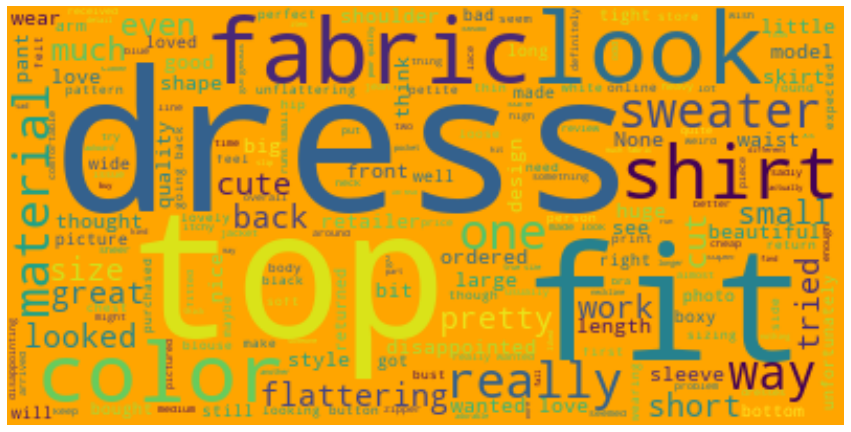

In [29]:
# Create wordcloud of not_recommended reviews:
wordcloud = WordCloud(background_color="orange").generate(" ".join(not_recommended['Review'])) 

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")

plt.show()

In [30]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - meaning either single or two word combination will be extracted
vectorizer= TfidfVectorizer(min_df=.02, max_df=.7, ngram_range=(1,2), 
                            tokenizer=lambda doc: doc, lowercase=False)
vectorizer.fit(text_df['Filtered_review'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=0.7, max_features=None,
                min_df=0.02, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x1c230d23b0>, use_idf=True,
                vocabulary=None)

In [31]:
# Getting the total n-gram count
len(vectorizer.vocabulary_)

232

In [32]:
# Creating the bag-of-words representation
vec_counts = vectorizer.transform(text_df['Filtered_review'])
print('sparse matrix shape:', vec_counts.shape)
print('nonzero count:', vec_counts.nnz)

sparse matrix shape: (23486, 232)
nonzero count: 304557


In [33]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
tfid = transformer.fit_transform(vec_counts)
tfid

<23486x232 sparse matrix of type '<class 'numpy.float64'>'
	with 304557 stored elements in Compressed Sparse Row format>

In [34]:
# Getting a list of all n-grams
tfid = tfid.toarray()
vocab = vectorizer.get_feature_names()

# Putting weighted n-grams into a DataFrame
model = pd.DataFrame(tfid, columns=vocab)
model.head(10)

,absolutely,actually,add,adorable,amazing,area,arm,beautiful,best,better,big,bit,black,blouse,blue,body,boot,bought,boxy,bra,bust,button,buy,casual,chest,color,come,comfortable,comfy,compliment,cut,cute,day,decided,definitely,design,detail,did,didnt,different,disappointed,doe,doesnt,dont,drape,dress,dressed,easy,extra,fabric,fall,favorite,feel,felt,feminine,figure,fine,fit,fit great,fit perfectly,fit true,fitted,flattering,flowy,fun,glad,going,good,gorgeous,got,great,green,happy,high,hip,hit,huge,id,im,im lb,issue,ive,jacket,jean,just,knee,lace,large,larger,lb,leg,legging,length,light,lightweight,like,liked,little,long,longer,look,look great,look like,looked,looking,loose,lot,love,love dress,loved,lovely,low,m,make,material,maybe,medium,model,neck,need,nice,nicely,normally,online,order,ordered,overall,pair,pant,pattern,perfect,perfectly,person,petite,photo,picture,piece,pocket,pretty,price,print,probably,problem,purchase,purchased,quality,quite,really,received,recommend,red,reference,regular,retailer,return,review,reviewer,right,run,run large,run small,s,said,sale,saw,say,shape,sheer,shirt,short,shorter,shoulder,size,size small,sized,sizing,skinny,skirt,sleeve,slightly,small,smaller,soft,store,stretch,style,summer,super,sure,sweater,tall,tank,tee,thing,think,thought,tight,time,top,tried,true,true size,try,tt,underneath,unfortunately,unique,usual,usually,usually wear,versatile,waist,wait,want,wanted,warm,wash,wasnt,way,wear,wearing,weight,went,white,wide,wish,wore,work,worn,worth,x,year
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [35]:
# Merging dataset: 
df = pd.merge(df, model, left_index=True, right_index=True)
df.drop(['Review'], axis=1, inplace=True)
df.head()

,ID,Age,Rating,Recommended,Pos_feedback,Class,Review_length,Polarity,Subjectivity,Division_General,Division_General Petite,Division_Initmates,Department_Bottoms,Department_Dresses,Department_Intimate,Department_Jackets,Department_Tops,Department_Trend,absolutely,actually,add,adorable,amazing,area,arm,beautiful,best,better,big,bit,black,blouse,blue,body,boot,bought,boxy,bra,bust,button,buy,casual,chest,color,come,comfortable,comfy,compliment,cut,cute,day,decided,definitely,design,detail,did,didnt,different,disappointed,doe,doesnt,dont,drape,dress,dressed,easy,extra,fabric,fall,favorite,feel,felt,feminine,figure,fine,fit,fit great,fit perfectly,fit true,fitted,flattering,flowy,fun,glad,going,good,gorgeous,got,great,green,happy,high,hip,hit,huge,id,im,im lb,issue,ive,jacket,jean,just,knee,lace,large,larger,lb,leg,legging,length,light,lightweight,like,liked,little,long,longer,look,look great,look like,looked,looking,loose,lot,love,love dress,loved,lovely,low,m,make,material,maybe,medium,model,neck,need,nice,nicely,normally,online,order,ordered,overall,pair,pant,pattern,perfect,perfectly,person,petite,photo,picture,piece,pocket,pretty,price,print,probably,problem,purchase,purchased,quality,quite,really,received,recommend,red,reference,regular,retailer,return,review,reviewer,right,run,run large,run small,s,said,sale,saw,say,shape,sheer,shirt,short,shorter,shoulder,size,size small,sized,sizing,skinny,skirt,sleeve,slightly,small,smaller,soft,store,stretch,style,summer,super,sure,sweater,tall,tank,tee,thing,think,thought,tight,time,top,tried,true,true size,try,tt,underneath,unfortunately,unique,usual,usually,usually wear,versatile,waist,wait,want,wanted,warm,wash,wasnt,way,wear,wearing,weight,went,white,wide,wish,wore,work,worn,worth,x,year
0,767,33,4,1,0,5,4,0.000,0.000,0,0,1,0,0,1,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1080,34,5,1,4,3,4,0.000,0.000,1,0,0,0,1,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [36]:
print(df.shape)

(23486, 250)


### IV. Building sentiment classifier:

In [37]:
# Split df into target and explanatory variables:
X = df.drop(['Recommended'], axis=1)
y = df['Recommended']
print(X.shape)
print(y.shape)

(23486, 249)
(23486,)


In [38]:
X1 =X.copy()

In [39]:
# Scaling the dataset:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [40]:
# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17614, 249) (17614,)
(5872, 249) (5872,)


### 1. Class imbalance :

Now let's check to see if our dataset suffers from class imbalance and how to resolve this issue.

In [41]:
# Inspect target variable for class imbalance:
y_train.value_counts()

1    14534
0     3080
Name: Recommended, dtype: int64

It looks like our dataset does suffer from class imbalance. As we can see, about 82% of our data has target = 1. This class imbalance can create a problem in terms of model assumptions, and will give us a misleading accuracy score when we evaluate our models later. To solve this issue, we'll apply SMOTE oversampling technique to our dataset to avoid class imbalance.

In [42]:
# Apply SMOTE to avoid class imbalance:
sm = SMOTE(random_state = 123)

X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [43]:
pd.Series(y_train).value_counts()

1    14534
0    14534
dtype: int64

We just split the dataset into train and test set with a test size of 25%. Let's now build some classification models and see which one performs best!

#### 1. Naive Bayes Classification:

In [44]:
# Naive Bayes Classification:
nbc = GaussianNB()
%timeit nbc.fit(X_train, y_train)

print('Accuracy on train set is {}'.format(accuracy_score(y_train, nbc.predict(X_train))))
print('Accuracy on test set is {}'.format(accuracy_score(y_test, nbc.predict(X_test))))
print('F1 score is {}'.format(metrics.f1_score(y_test, nbc.predict(X_test))))
print('Precision score is {}'.format(metrics.precision_score(y_test, nbc.predict(X_test))))
print('Recall score is {}'.format(metrics.recall_score(y_test, nbc.predict(X_test))))

122 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy on train set is 0.7939314710334389
Accuracy on test set is 0.7162806539509536
F1 score is 0.8008606263447287
Precision score is 0.9341885108756275
Recall score is 0.700836820083682


Naive Bayes model seems to give us a very poor prediction. The accuracy on our test data is only 69%, which is worse than if we just mandatorily predict that all items are recommended.

Let's try logistic regression next to see if the performance improves.

#### 2. Logistic Regression Model:

In [45]:
# Logistic regression:
lr = LogisticRegressionCV(cv=5, random_state=1234)
%timeit lr.fit(X_train, y_train)

print('Accuracy on train set is {}'.format(accuracy_score(y_train, lr.predict(X_train))))
print('Accuracy on test set is {}'.format(accuracy_score(y_test, lr.predict(X_test))))
print('F1 score is {}'.format(metrics.f1_score(y_test, lr.predict(X_test))))
print('Precision score is {}'.format(metrics.precision_score(y_test, lr.predict(X_test))))
print('Recall score is {}'.format(metrics.recall_score(y_test, lr.predict(X_test))))

30.6 s ± 511 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set is 0.9541764139259667
Accuracy on test set is 0.9327316076294278
F1 score is 0.9576407506702412
Precision score is 0.9823982398239824
Recall score is 0.9341004184100419


Wow! Logistic regression gives us an accuracy score of 93.27%, significantly higher than Naive Bayes model above.

#### 3. Random forest classifier:

In [46]:
# Random forest classification:
rfc = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=1234 )
%timeit rfc.fit(X_train, y_train)

print('Accuracy on train set is {}'.format(accuracy_score(y_train, rfc.predict(X_train))))
print('Accuracy on test set is {}'.format(accuracy_score(y_test, rfc.predict(X_test))))
print('F1 score is {}'.format(metrics.f1_score(y_test, rfc.predict(X_test))))
print('Precision score is {}'.format(metrics.precision_score(y_test, rfc.predict(X_test))))
print('Recall score is {}'.format(metrics.recall_score(y_test, rfc.predict(X_test))))

1min 14s ± 2.77 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set is 1.0
Accuracy on test set is 0.9317098092643051
F1 score is 0.9571352218065206
Precision score is 0.9785792349726776
Recall score is 0.9366108786610878


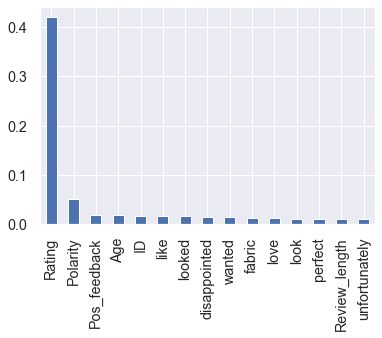

In [52]:
# Plot feature importance
important_features = pd.Series(data=rfc.feature_importances_,index=X1.columns)
important_features.sort_values(ascending=False).head(15).plot(kind='bar')

#### 4. Support Vector Machine classifier

In [48]:
# Support Vector machine:
for c in [0.01, 0.05, 0.25, 0.5]:
    svm = LinearSVC(C=c)
    %timeit svm.fit(X_train, y_train)
    print('Accuracy on train set for C=%s: %s' % (c, accuracy_score(y_train, svm.predict(X_train))))
    print('Accuracy on test set for C=%s: %s' % (c, accuracy_score(y_test, svm.predict(X_test))))
    print('F1 score is {}'.format(metrics.f1_score(y_test, svm.predict(X_test))))
    print('Precision score is {}'.format(metrics.precision_score(y_test, svm.predict(X_test))))
    print('Recall score is {}'.format(metrics.recall_score(y_test, svm.predict(X_test))))
    print('-------------------------')

1.2 s ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set for C=0.01: 0.9497041420118343
Accuracy on test set for C=0.01: 0.93358310626703
F1 score is 0.9579831932773109
Precision score is 0.9875610839626833
Recall score is 0.9301255230125522
-------------------------
3.39 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set for C=0.05: 0.9517338654190175
Accuracy on test set for C=0.05: 0.9339237057220708
F1 score is 0.9582346609257266
Precision score is 0.9869179600886918
Recall score is 0.9311715481171549
-------------------------
3.26 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set for C=0.25: 0.9537635888262006
Accuracy on test set for C=0.25: 0.9340940054495913
F1 score is 0.9584362581892385
Precision score is 0.9847715736040609
Recall score is 0.9334728033472803
-------------------------
3.25 s ± 89.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set for C=

In [49]:
# Top features from the text:
feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), svm.coef_[0]
    )
}

for most_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:20]:
    print(most_positive)
    
print('\n')
for most_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:20]:
    print(most_negative)

('flowy', 2.279496841642679)
('huge', 1.752269874358987)
('white', 1.11684994562331)
('add', 1.0800976689968182)
('disappointed', 1.057663527236118)
('button', 0.9109717397618722)
('pocket', 0.8936829422960113)
('waist', 0.8883807067911145)
('fine', 0.8562606101729738)
('decided', 0.8144934022829318)
('wearing', 0.8143026940509653)
('usually wear', 0.7802671786221342)
('ive', 0.7639361301803257)
('tight', 0.7494761438037317)
('favorite', 0.7322570290172691)
('cute', 0.6976025986864418)
('comfy', 0.6955391196332659)
('shape', 0.6929527933428502)
('bra', 0.690935462712706)
('green', 0.6667034046587133)


('received', -0.8951873178986336)
('year', -0.8633468913668001)
('print', -0.8028626010125423)
('nicely', -0.7913202395397652)
('light', -0.7797765542267221)
('liked', -0.7165577330795119)
('nice', -0.6979150191874065)
('sleeve', -0.6451654672666445)
('going', -0.6351685925228542)
('feminine', -0.6236707870512194)
('model', -0.6116633764289008)
('said', -0.5916840095355882)
('pant', -0.5

#### XGBoost ensemble classifier

In [50]:
# XGBoost
xgb = XGBClassifier(objective ='reg:logistic',
                    booster = 'gbtree',
                    subsample = 0.5,
                    min_child_weight = 1,
                    colsample_bytree = 0.3,
                    learning_rate = 0.2,
                    alpha = 1, 
                    n_estimators = 100)

%timeit xgb.fit(X_train, y_train)

print('Accuracy on train set is {}'.format(accuracy_score(y_train, xgb.predict(X_train))))
print('Accuracy on test set is {}'.format(accuracy_score(y_test, xgb.predict(X_test))))
print('F1 score is {}'.format(metrics.f1_score(y_test, xgb.predict(X_test))))
print('Precision score is {}'.format(metrics.precision_score(y_test, xgb.predict(X_test))))
print('Recall score is {}'.format(metrics.recall_score(y_test, xgb.predict(X_test))))

23.7 s ± 967 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy on train set is 0.9677996422182469
Accuracy on test set is 0.9375
F1 score is 0.9609200298157811
Precision score is 0.9785296031229668
Recall score is 0.9439330543933054


### Conclusion:

Our best performed model is XGBoost, with a accuracy score of 93.97%. The next best model is Support vector classifer. In term of timing, XGBoost took 23.7s to run while logistic regression and SVM took significantly less. 
